In [1]:
# Load required Python packages
import os, re, requests, logging, calplot
import pandas as pd
import dask.dataframe as dd
import multiprocessing as mp
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar
ProgressBar().register()
from tqdm import tqdm
from itertools import product
from eu_country_codes import COUNTRY_CODES

In [2]:
# Function to download remote file to the disk
def urlDownload(urlLink, showProgress = False):
  with requests.get(urlLink, stream=True) as r:
    fileSize = int(r.headers.get('Content-Length'))
    fileName = r.headers.get('Content-Disposition').split("filename=")[1]
    if not os.path.exists(fileName) or os.path.getsize(fileName) != fileSize:
      block_size = 1024
      if showProgress:
        print(f"Downloading {fileName}")
        progress_bar = tqdm(total=fileSize, unit='iB', unit_scale=True)
      with open(fileName, 'wb') as file:
        for data in r.iter_content(block_size):
          if showProgress:
            progress_bar.update(len(data))
          file.write(data)
      if showProgress:
        progress_bar.close()
    return fileName

In [3]:
# import requests
# from tqdm import tqdm  # Import tqdm for the progress bar

def urlDownload(urlLink, showProgress=False):
    with requests.get(urlLink, stream=True) as r:
        fileSize = int(r.headers.get('Content-Length'))
        fileName = r.headers.get('Content-Disposition').split("filename=")[1]

        with open(fileName, 'wb') as f, tqdm(total=fileSize, unit='B', unit_scale=True, unit_divisor=1024, disable=not showProgress) as bar:
            for data in r.iter_content(chunk_size=1024):
                bar.update(len(data))
                f.write(data)

    return fileName

# Download the newest data
urlLocation = 'https://aqicn.org/data-platform/covid19/report/39374-7694ec07/'
csvFile = urlDownload(urlLocation, showProgress=True)
print(csvFile)

100%|██████████| 216M/216M [00:29<00:00, 7.57MB/s] 

waqi-covid19-airqualitydata-2023.csv


In [4]:
# import pandas as pd
# from itertools import product  # Import the product function

# Create lists of year and quarter names
yNames = [str(i) for i in range(2019, 2022)]
qNames = ["Q" + str(i) for i in range(1, 5)]

# Create a data frame with the url locations and year/quarter combinations
DF = pd.DataFrame(list(product(yNames, qNames)), columns=['yNames', 'qNames'])
DF.insert(loc=0, column='urlLocation', value=urlLocation)

# Combine url location and year/quarter combinations into a single column
DF['urlLocations'] = DF['urlLocation'] + DF['yNames'] + DF['qNames']
DF.drop(['urlLocation', 'yNames', 'qNames'], axis=1, inplace=True)

DF

,urlLocations
0,https://aqicn.org/data-platform/covid19/report...
1,https://aqicn.org/data-platform/covid19/report...
2,https://aqicn.org/data-platform/covid19/report...
3,https://aqicn.org/data-platform/covid19/report...
4,https://aqicn.org/data-platform/covid19/report...
5,https://aqicn.org/data-platform/covid19/report...
6,https://aqicn.org/data-platform/covid19/report...
7,https://aqicn.org/data-platform/covid19/report...
8,https://aqicn.org/data-platform/covid19/report...
9,https://aqicn.org/data-platform/covid19/report...


In [5]:
# Download legacy data (sequentially)
csvFiles = DF.apply(lambda x : urlDownload(x[0], showProgress = True), axis=1)

100%|██████████| 25.3M/25.3M [00:06<00:00, 4.31MB/s]
100%|██████████| 26.9M/26.9M [00:06<00:00, 4.60MB/s]
100%|██████████| 30.1M/30.1M [00:07<00:00, 4.36MB/s]
100%|██████████| 29.8M/29.8M [00:07<00:00, 3.97MB/s]
100%|██████████| 27.7M/27.7M [00:25<00:00, 1.13MB/s]
100%|██████████| 31.1M/31.1M [00:25<00:00, 1.28MB/s]
100%|██████████| 30.9M/30.9M [00:25<00:00, 1.25MB/s]
100%|██████████| 30.3M/30.3M [00:22<00:00, 1.42MB/s]
100%|██████████| 30.5M/30.5M [00:24<00:00, 1.28MB/s]
100%|██████████| 30.3M/30.3M [00:20<00:00, 1.58MB/s]
100%|██████████| 29.4M/29.4M [00:19<00:00, 1.57MB/s]
100%|██████████| 28.2M/28.2M [00:19<00:00, 1.55MB/s]


In [6]:
# import os  # Import the os module
# Delete downloaded legacy data files
for delFile in csvFiles:
    os.unlink(delFile)

In [7]:
# Download legacy data (in parallel)
import dask.dataframe as dd
import multiprocessing as mp  # Import multiprocessing module
DDF = dd.from_pandas(DF, npartitions=mp.cpu_count())
csvFiles = DDF.apply(lambda x : urlDownload(x[0]), axis=1, meta=pd.Series(dtype="str")).compute(scheduler='threads')

[########################################] | 100% Completed | 32.79 s


In [8]:
import pandas as pd

# Define the columns to load
meta_cols = ['Date', 'Country', 'City', 'Specie']
main_column = 'median' # 'count', 'min', 'max', 'median', 'variance'
selected_cols = meta_cols + [main_column]

# Read the newest data file and skip the first 4 lines
DF = pd.read_csv(csvFile, skiprows=4, usecols=selected_cols)

# Leave EU data, rename main column to Value
selectEU = DF['Country'].isin(COUNTRY_CODES)
newTable = DF[selectEU].rename(columns={main_column: 'Value'})
print(newTable)

               Date Country                        City         Specie  Value
0        2022-01-06      ES  Las Palmas de Gran Canaria  precipitation   99.2
1        2022-11-19      ES  Las Palmas de Gran Canaria  precipitation   99.0
2        2023-02-16      ES  Las Palmas de Gran Canaria  precipitation    0.3
3        2022-03-24      ES  Las Palmas de Gran Canaria  precipitation   99.0
4        2022-09-30      ES  Las Palmas de Gran Canaria  precipitation   99.1
...             ...     ...                         ...            ...    ...
4175251  2023-04-23      SK                  Bratislava            no2    7.8
4175252  2022-01-19      SK                  Bratislava            no2   19.2
4175253  2022-02-16      SK                  Bratislava            no2    7.8
4175254  2022-10-19      SK                  Bratislava            no2   12.4
4175255  2023-10-07      SK                  Bratislava            no2    7.4

[1175321 rows x 5 columns]


In [9]:
# Read legacy data files (sequentially)
fileNamesQ = [f for f in os.listdir('.') if re.match(r'^.*Q\d.csv$', f)]
DF = pd.concat((pd.read_csv(f, skiprows=4, usecols=selected_cols) for f in fileNamesQ), ignore_index=True)
selectEU = DF['Country'].isin(COUNTRY_CODES)
oldTable = DF[selectEU].rename(columns={main_column: 'Value'})
print(oldTable)

               Date Country       City     Specie  Value
1695     2021-06-08      HU   Debrecen         co    2.2
1696     2021-06-18      HU   Debrecen         co    1.8
1697     2021-03-30      HU   Debrecen         co    5.4
1698     2021-04-13      HU   Debrecen         co    2.4
1699     2021-05-29      HU   Debrecen         co    2.2
...             ...     ...        ...        ...    ...
6795449  2019-01-17      NL  The Hague  wind-gust   14.5
6795450  2019-01-26      NL  The Hague  wind-gust   18.0
6795451  2019-02-07      NL  The Hague  wind-gust   22.4
6795452  2019-02-19      NL  The Hague  wind-gust   14.2
6795453  2019-03-23      NL  The Hague  wind-gust    7.7

[1942766 rows x 5 columns]


In [10]:
# Read legacy data files (in parallel)
fileNamesQ = [f for f in os.listdir('.') if re.match(r'^.*Q\d.csv$', f)]
DF = dd.compute(dd.read_csv(fileNamesQ, skiprows=4, usecols=selected_cols))[0]
selectEU = DF['Country'].isin(COUNTRY_CODES)
oldTable = DF[selectEU].rename(columns={main_column: 'Value'})
print(oldTable)

[########################################] | 100% Completed | 1.43 ss
              Date Country       City     Specie  Value
1695    2021-06-08      HU   Debrecen         co    2.2
1696    2021-06-18      HU   Debrecen         co    1.8
1697    2021-03-30      HU   Debrecen         co    5.4
1698    2021-04-13      HU   Debrecen         co    2.4
1699    2021-05-29      HU   Debrecen         co    2.2
...            ...     ...        ...        ...    ...
488233  2019-01-17      NL  The Hague  wind-gust   14.5
488234  2019-01-26      NL  The Hague  wind-gust   18.0
488235  2019-02-07      NL  The Hague  wind-gust   22.4
488236  2019-02-19      NL  The Hague  wind-gust   14.2
488237  2019-03-23      NL  The Hague  wind-gust    7.7

[1942766 rows x 5 columns]


In [11]:
specie_summary = oldTable['Specie'].value_counts()

# Print the summary
print(specie_summary)

temperature      189871
humidity         189721
pressure         189586
pm10             188751
no2              185149
wind-speed       174276
o3               163840
pm25             136539
wind-gust        133325
so2              132236
dew              127765
co                91388
precipitation     14469
wind speed        13881
wind gust         11891
wd                   78
Name: Specie, dtype: int64


In [12]:
# Assuming oldTable and newTable are your old and new data tables
DF = pd.concat([oldTable, newTable])

# Sorting and removing duplicates
dataTableEU = DF.sort_values(by=['Country', 'City', 'Date']).drop_duplicates()

# Filtering for Netherlands
dataTableNetherlands = dataTableEU[dataTableEU['Country'] == 'NL']

# Keeping only specified columns
selected_columns = ['pm10', 'pm25', 'no2', 'o3', 'so2', 'co']
dataTableNetherlands = dataTableNetherlands[dataTableNetherlands['Specie'].isin(selected_columns)]

# Print the DataFrame for Netherlands with selected columns
print(dataTableNetherlands)

               Date Country       City Specie  Value
482829   2018-12-31      NL  Amsterdam    no2   10.1
483281   2018-12-31      NL  Amsterdam   pm25   44.0
483347   2018-12-31      NL  Amsterdam     o3   12.1
483421   2018-12-31      NL  Amsterdam    so2    0.2
483724   2018-12-31      NL  Amsterdam     co    2.5
...             ...     ...        ...    ...    ...
3213255  2023-12-27      NL    Utrecht   pm10   12.0
3208796  2023-12-28      NL    Utrecht    so2    0.2
3210022  2023-12-28      NL    Utrecht   pm25   18.0
3210799  2023-12-28      NL    Utrecht    no2    2.8
3213144  2023-12-28      NL    Utrecht   pm10   10.0

[92982 rows x 5 columns]


In [13]:
# Descriptive statistics for daily values of selected variables
selectedVars = ['pm10', 'pm25', 'no2', 'o3', 'so2', 'co']
selectedIdx = dataTableNetherlands['Specie'].isin(selectedVars)
dataTableNetherlands = dataTableNetherlands[selectedIdx]
dataTableNetherlands.groupby('Specie')['Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Specie,,,,,,,,
co,4473.0,2.529555,0.782971,0.7,1.9,2.4,3.0,7.9
no2,20077.0,8.236490,4.464272,0.9,5.1,7.2,10.3,36.9
o3,19205.0,20.140620,8.433960,0.1,15.0,20.8,25.7,64.9
pm10,20064.0,16.703648,6.922035,3.0,12.0,15.0,20.0,64.0
pm25,19262.0,36.461582,19.473170,1.0,22.0,32.0,48.0,158.0
so2,9901.0,0.464084,0.523229,0.1,0.2,0.3,0.6,12.8


In [14]:
# 2021-10-03 Barcelona fix
print(dataTableNetherlands)
dataTableNetherlands = dataTableNetherlands.groupby(['Date', 'Country', 'City', 'Specie'])[['Value']].mean().reset_index()
print(dataTableNetherlands)

               Date Country       City Specie  Value
482829   2018-12-31      NL  Amsterdam    no2   10.1
483281   2018-12-31      NL  Amsterdam   pm25   44.0
483347   2018-12-31      NL  Amsterdam     o3   12.1
483421   2018-12-31      NL  Amsterdam    so2    0.2
483724   2018-12-31      NL  Amsterdam     co    2.5
...             ...     ...        ...    ...    ...
3213255  2023-12-27      NL    Utrecht   pm10   12.0
3208796  2023-12-28      NL    Utrecht    so2    0.2
3210022  2023-12-28      NL    Utrecht   pm25   18.0
3210799  2023-12-28      NL    Utrecht    no2    2.8
3213144  2023-12-28      NL    Utrecht   pm10   10.0

[92982 rows x 5 columns]
             Date Country       City Specie  Value
0      2018-12-31      NL  Amsterdam     co    2.5
1      2018-12-31      NL  Amsterdam    no2   10.1
2      2018-12-31      NL  Amsterdam     o3   12.1
3      2018-12-31      NL  Amsterdam   pm10   19.0
4      2018-12-31      NL  Amsterdam   pm25   44.0
...           ...     ...       

In [15]:
dataTableNetherlandsAPI = dataTableNetherlands.pivot_table(index=['Date', 'Country', 'City'], columns='Specie', values='Value').reset_index()
dataTableNetherlandsAPI["API"] = dataTableNetherlandsAPI[['pm10', 'pm25', 'no2', 'o3', 'so2', 'co']].max(axis=1)
dataTableNetherlandsAPI = dataTableNetherlandsAPI.dropna(subset=["API"])
print(dataTableNetherlandsAPI)
dataTableNetherlandsAPI.to_csv(r"/Users/myPath/Name1.csv", index=False)

Specie        Date Country        City   co   no2    o3  pm10  pm25  so2   API
0       2018-12-31      NL   Amsterdam  2.5  10.1  12.1  19.0  44.0  0.2  44.0
1       2018-12-31      NL       Breda  NaN   9.2   9.7  16.0  46.0  NaN  46.0
2       2018-12-31      NL   Dordrecht  NaN   7.8   9.5  15.0  34.0  NaN  34.0
3       2018-12-31      NL   Eindhoven  NaN   8.2   8.3  24.0  59.0  NaN  59.0
4       2018-12-31      NL   Groningen  NaN   6.1  16.5  23.0  38.0  NaN  38.0
...            ...     ...         ...  ...   ...   ...   ...   ...  ...   ...
20059   2023-12-28      NL  Maastricht  NaN   2.6   NaN   5.0  17.0  0.1  17.0
20060   2023-12-28      NL    Nijmegen  NaN   1.7   NaN   7.0  31.0  NaN  31.0
20061   2023-12-28      NL   Rotterdam  NaN   5.3   NaN  10.0  17.0  0.2  17.0
20062   2023-12-28      NL   The Hague  NaN   3.9   NaN  12.0  19.0  0.7  19.0
20063   2023-12-28      NL     Utrecht  NaN   2.8   NaN  10.0  18.0  0.2  18.0

[20064 rows x 10 columns]


In [16]:
import pandas as pd

dataTableNetherlandsAPI['Date'] = pd.to_datetime(dataTableNetherlandsAPI['Date'])
dataTableNetherlandsAPI['Year'] = dataTableNetherlandsAPI['Date'].dt.year
dataTableNetherlandsAPI['Month'] = dataTableNetherlandsAPI['Date'].dt.month
top_5_highest_api = dataTableNetherlandsAPI.nlargest(5, 'API')
print("Top 5 results with the highest API in the Netherlands:")
print(top_5_highest_api[['Year', 'Month', 'API']])

Top 5 results with the highest API in the Netherlands:
Specie  Year  Month    API
1084    2019      4  158.0
279     2019      1  154.0
4031    2020      1  152.0
4032    2020      1  152.0
1080    2019      4  150.0


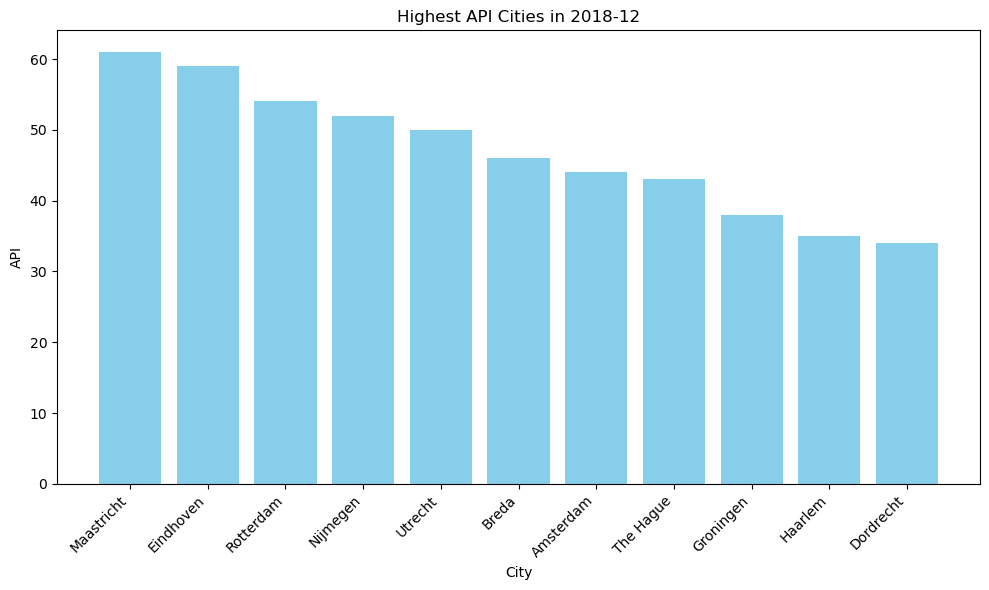

In [17]:
import matplotlib.pyplot as plt
max_api_row = pd.DataFrame(dataTableNetherlandsAPI)

selected_year = max_api_row['Year'].iloc[0]
selected_month = max_api_row['Month'].iloc[0]

selected_data = dataTableNetherlandsAPI[(dataTableNetherlandsAPI['Year'] == selected_year) & (dataTableNetherlandsAPI['Month'] == selected_month)]
sorted_data = selected_data.sort_values(by='API', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(sorted_data['City'], sorted_data['API'], color='skyblue')
plt.title(f'Highest API Cities in {selected_year}-{selected_month}')
plt.xlabel('City')
plt.ylabel('API')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Descriptive statistics for yearly API
myCity = 'Maastricht'
myTable = dataTableNetherlandsAPI[(dataTableNetherlandsAPI['City']==myCity) & (dataTableNetherlandsAPI['Date']>='2019-01-01')][["Date", "API"]]
myTable.groupby(pd.to_datetime(myTable['Date']).dt.year).describe()

Specie    API                                                     
        count       mean        std   min   25%   50%   75%    max
Date                                                              
2019    365.0  39.807397  19.908757  16.0  25.0  32.9  53.0  158.0
2020    366.0  37.041530  18.240392  13.0  25.0  30.0  46.0  152.0
2021    365.0  37.217945  17.583263  13.0  23.1  34.0  46.0   99.0
2022    365.0  39.807123  18.775870  17.0  25.0  34.0  50.0  112.0
2023    362.0  32.994751  16.560459   5.0  21.6  29.1  42.0   99.0

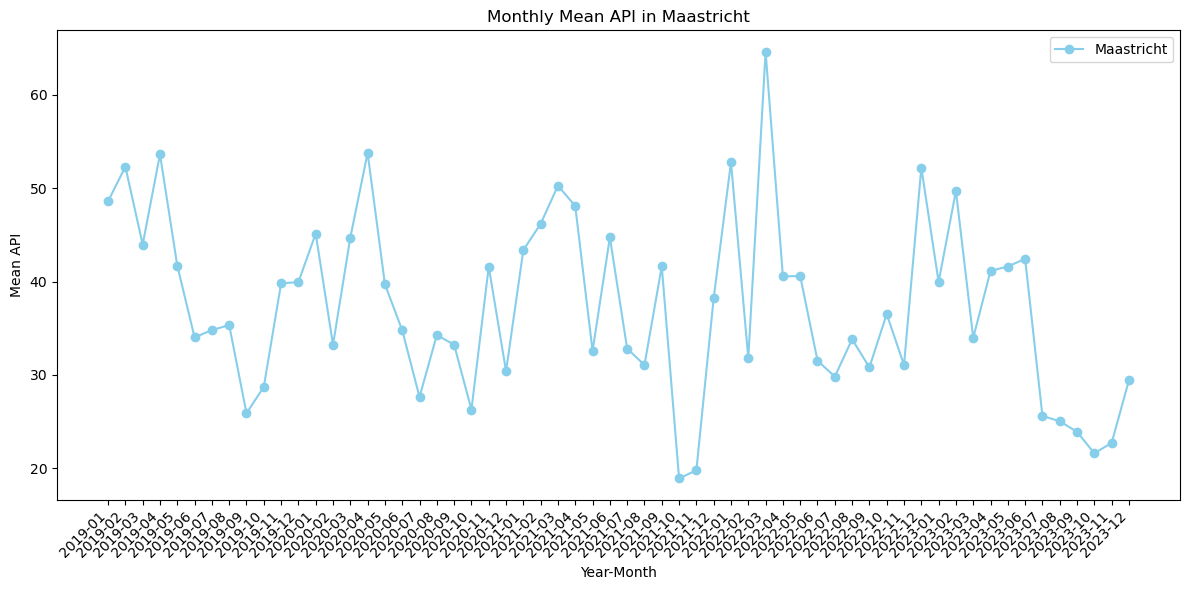

In [19]:
myTable['Year'] = pd.to_datetime(myTable['Date']).dt.year
myTable['Month'] = pd.to_datetime(myTable['Date']).dt.month

monthly_stats = myTable.groupby(['Year', 'Month'])['API'].mean().reset_index()

monthly_stats['YearMonth'] = monthly_stats[['Year', 'Month']].apply(lambda x: f'{x[0]}-{x[1]:02}', axis=1)

plt.figure(figsize=(12, 6))
plt.plot(monthly_stats['YearMonth'], monthly_stats['API'], marker='o', color='skyblue', label=myCity)
plt.title(f'Monthly Mean API in {myCity}')
plt.xlabel('Year-Month')
plt.ylabel('Mean API')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

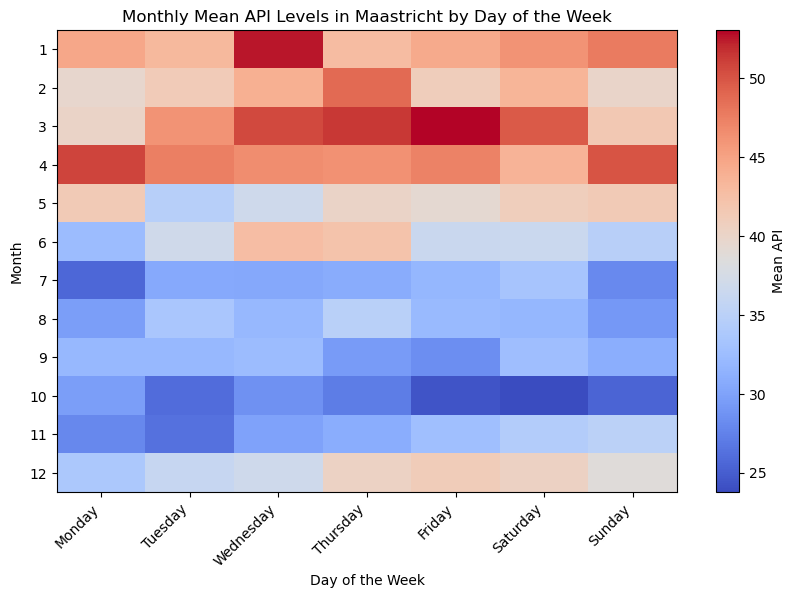

In [29]:
myTable['Date'] = pd.to_datetime(myTable['Date'])
myTable['Month'] = myTable['Date'].dt.month

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
myTable['DayOfWeek'] = pd.Categorical(myTable['Date'].dt.day_name(), categories=day_order, ordered=True)

monthly_stats = myTable.groupby(['Month', 'DayOfWeek'])['API'].mean().reset_index()

pivot_table = monthly_stats.pivot(index='Month', columns='DayOfWeek', values='API')

plt.figure(figsize=(10, 6))
plt.imshow(pivot_table, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Mean API')
plt.title('Monthly Mean API Levels in Maastricht by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns, rotation=45, ha='right')
plt.yticks(range(len(pivot_table.index)), pivot_table.index)
plt.show()

(<Figure size 1250x850 with 6 Axes>,
 array([<Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>], dtype=object))

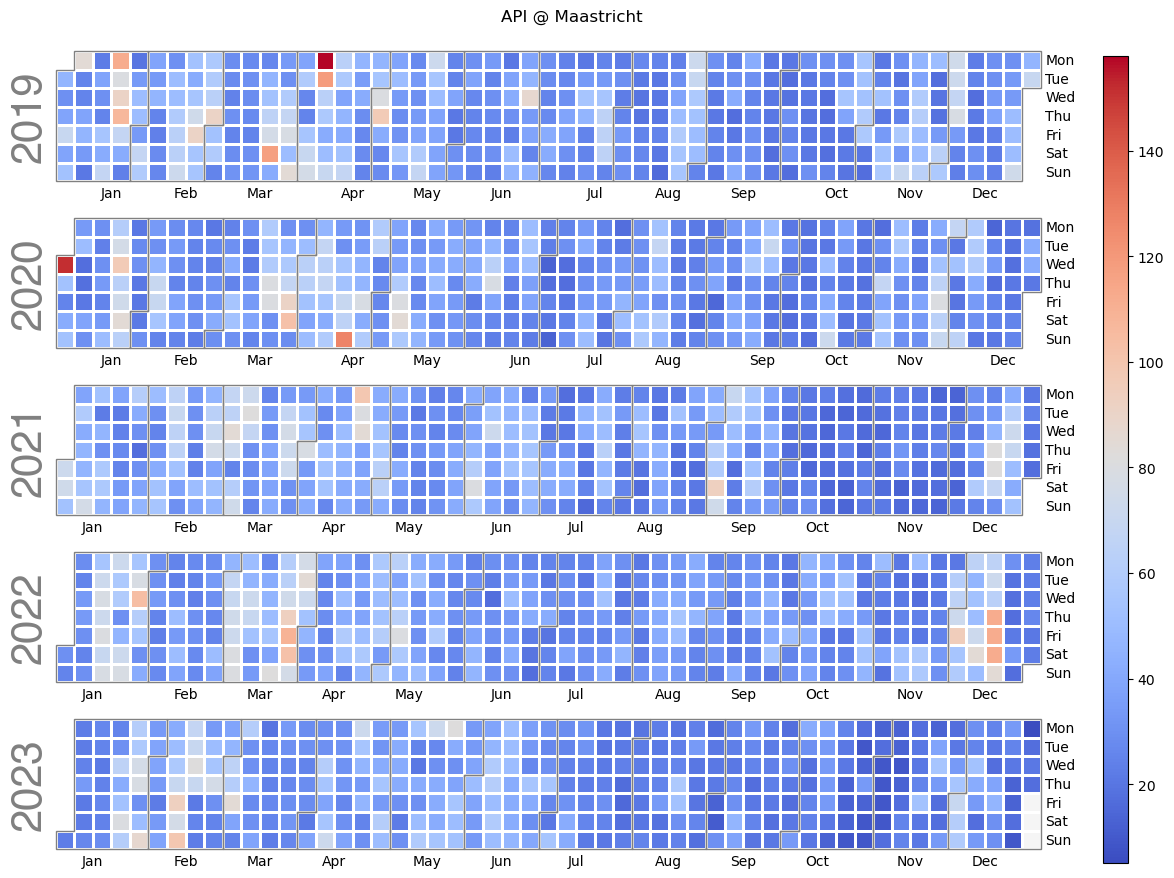

In [21]:
# Plot API time series calendar heatmap
pdTimeSeries = pd.Series(myTable['API'].values, index=pd.DatetimeIndex(myTable['Date']))
logging.getLogger('matplotlib.font_manager').disabled = True
calplot.calplot(pdTimeSeries, dropzero=True, cmap='coolwarm', suptitle='API @ ' + myCity)

<Axes: title={'center': 'API @ Maastricht'}, xlabel='Time', ylabel='API'>

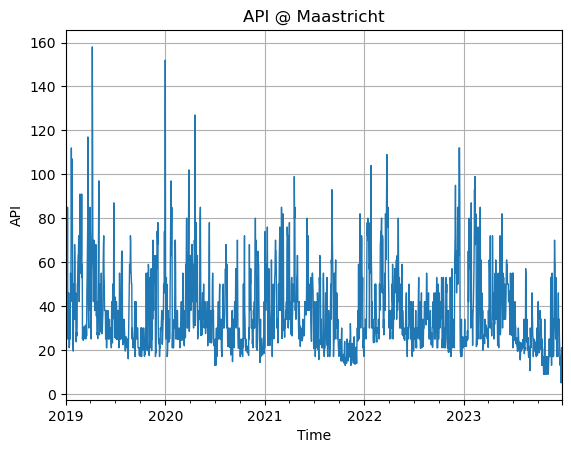

In [22]:
# Plot API time series dynamics
pdTimeSeries.plot(title='API @ ' + myCity, ylabel="API", xlabel="Time", lw=1, grid=True)